# Demo for Projection
- Include projecting a real portrait and perform relighting.

## Define the Settings

Setting up which GPU you are using.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

If you encounter error while building the plugins for StyleGAN2, it may probably be caused by the missing path of ninja. Thus, explicitly adding the path of ninja to the `PATH` environment variable may help.

You can query the path by typing `which ninja` in the conda environment and extract the directory component.

In [2]:
# Uncomment this line if you encounter the error (at least worth a try ;D)
# os.environ['PATH'] = os.environ['PATH'] + ":path-to-ninja(directory only)"

In [4]:
device = "cuda"

## Define the Utility Functions

In [5]:
import sys
sys.path.append("./modules/")
sys.path.append("./modules/models/")

import cv2
import dnnlib
import torch
import pickle
import mrcfile
import pyshtools
import numpy as np
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import imageio
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics

import warnings
warnings.filterwarnings("ignore")

In [6]:
@torch.no_grad()
def render_tensor(img: torch.Tensor, normalize: bool = True, nrow: int = 8) -> Image.Image:
    if type(img) == list:
        img = torch.cat(img, dim=0).expand(-1, 3, -1, -1)
    elif len(img.shape) == 3:
        img = img.expand(3, -1, -1)
    elif len(img.shape) == 4:
        img = img.expand(-1, 3, -1, -1)
    
    img = img.squeeze()
    
    if normalize:
        img = img / 2 + .5
    
    if len(img.shape) == 3:
        return Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 2:
        return Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 4:
        return Image.fromarray((make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [7]:
def to_tensor(img: Union[Image.Image, np.ndarray], normalize=True) -> torch.Tensor:
    if isinstance(img, Image.Image):
        img = np.array(img)
        if len(img.shape) > 2:
            img = img.transpose(2, 0, 1)
        else:
            img = img[None, ...]
    else:
        if img.shape[0] == img.shape[1]:
            img = img.transpose(2, 0, 1)
    if normalize:
        img = torch.from_numpy(img).to(torch.float32) / 127.5 - 1
    else:
        img = torch.from_numpy(img).to(torch.float32) / 255.
    return img[None, ...].to(device)

In [8]:
def load_sh(index):
    sh = np.loadtxt(os.path.join("../data/example_light", f"rotate_light_{index}.txt"))
    sh = sh[0:9] * 0.7
    sh = np.reshape(sh, (1, 9)).astype(np.float32)
    sh = torch.from_numpy(sh).to(device)
    return sh

rotating_sh_s = [
    load_sh("00"), 
    load_sh("01"), 
    load_sh("02"), 
    load_sh("03"), 
    load_sh("04"), 
    load_sh("05"), 
    load_sh("06"), 
    load_sh("00"), 
]

In [9]:
from modules.crop import *
from modules.pose import *
from modules.project import *
cropper = Cropper(device)
poser = Poser(device)
projector = Projector(
    device, 
    "../data/NeRFFaceLighting-ffhq-64.pkl", 
    "../data/encoder.pt"
)

__name__ facereconmodel False
__doc__ facereconmodel False
__package__ facereconmodel False
__loader__ facereconmodel False
__spec__ facereconmodel False
__file__ facereconmodel False
__cached__ facereconmodel False
__builtins__ facereconmodel False
np facereconmodel False
torch facereconmodel False
BaseModel facereconmodel False
networks facereconmodel False
ParametricFaceModel facereconmodel False
perceptual_loss facereconmodel False
photo_loss facereconmodel False
reg_loss facereconmodel False
reflectance_loss facereconmodel False
landmark_loss facereconmodel False
util facereconmodel False
MeshRenderer facereconmodel False
estimate_norm_torch facereconmodel False
savemat facereconmodel False
facereconmodel facereconmodel True
----------------- Options ---------------
                add_image: True                          
               bfm_folder: BFM                           
                bfm_model: BFM_model_front.mat           
                 camera_d: 10.0             

In [10]:
from external_dependencies.DPR.DPR import DPR
dpr = DPR(device)

## Load the Image

In [11]:
image = Image.open(os.path.join("./gallery", "example.jpg")).convert("RGB")

In [12]:
keypoints = eg3d_detect_keypoints(image)[0]
pred_coeffs = cropper.get_deep3d_coeffs(image, keypoints)
im = cropper.final_crop(image, keypoints)
img = (torch.from_numpy(np.array(im)).float().permute(2, 0, 1)[None, ...]/127.5-1).to(device)
pose = poser.get_pose(pred_coeffs)
sh = dpr.extract_lighting(img).squeeze()[None, ...]
cam = torch.cat([torch.from_numpy(pose["pose"]).to(device).reshape(-1, 16), projector.intrinsics.reshape(-1, 9)], dim=1).float()

## Projection & Relighting

In [14]:
G_opt, w_opt, sh_opt, w_opt_loss, sh_opt_loss, pti_loss = projector.project(im, cam, sh)

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [15]:
cam2world_pose = LookAtPoseSampler.sample(6*np.pi/12, np.pi/2, projector.cam_pivot, radius=projector.cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), projector.intrinsics.reshape(-1, 9)], 1)

In [16]:
out = G_opt.synthesis(w_opt, projector.mapping_lit(G_opt, sh_opt), camera_params, None, noise_mode="const")

In [17]:
relit_out = G_opt.synthesis(w_opt, projector.mapping_lit(G_opt, rotating_sh_s[3]), camera_params, None, noise_mode="const")

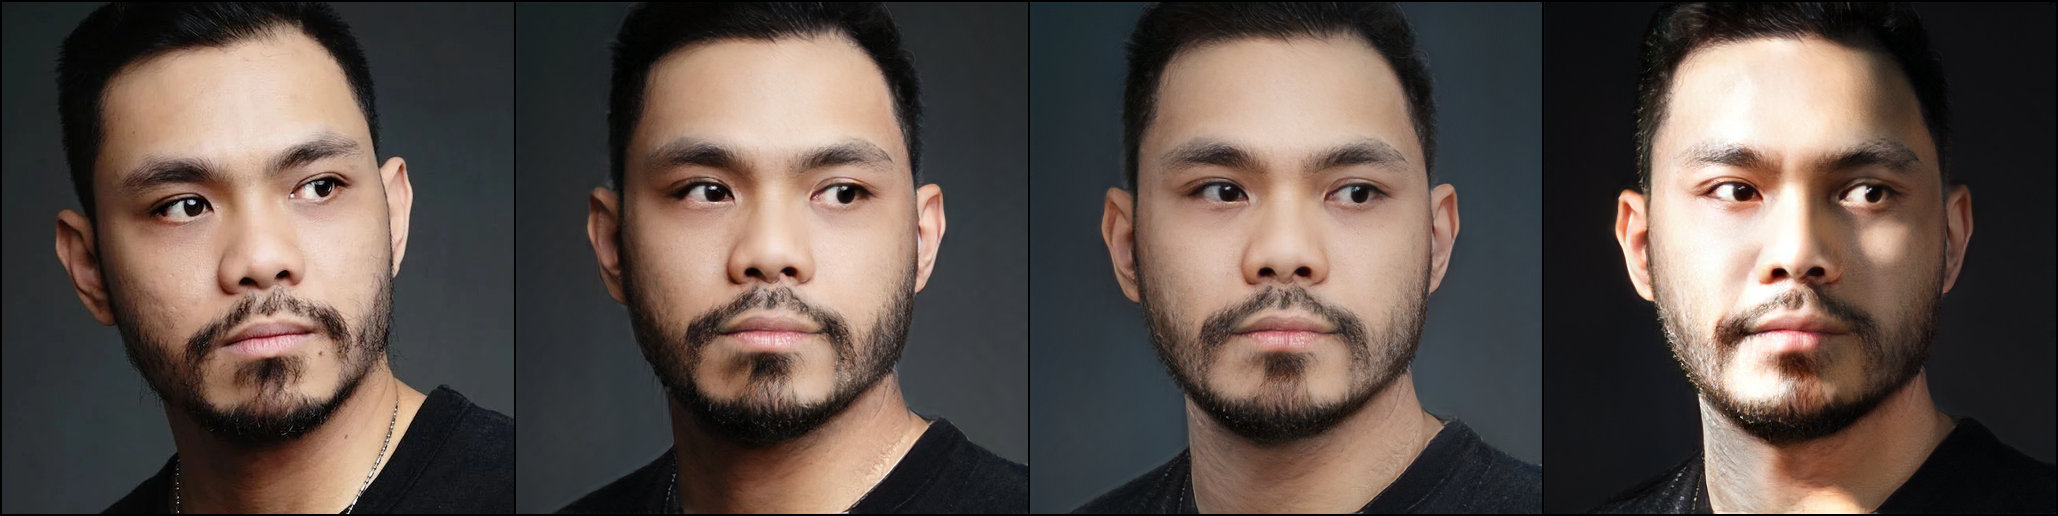

In [18]:
render_tensor([to_tensor(im), out["image"].clamp(-1, 1), out["image_albedo"].clamp(-1, 1), relit_out["image"].clamp(-1, 1)])